$u_t = -uu_x - u_{xx} - u_{xxxx}$

In [39]:
import matplotlib.pyplot as plt

# General imports
import numpy as np
import torch

# DeePyMoD imports
from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.data.burgers import burgers_delta
from deepymod.model.constraint import LeastSquares
from deepymod.model.func_approx import NN, Siren
from deepymod.model.library import Library1D
from deepymod.model.sparse_estimators import Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import Periodic, TrainTest, TrainTestPeriodic
from scipy.io import loadmat
import pysindy as ps

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cuda


In [40]:
def load_data():
    data = loadmat("../../PDE-READ/Matlab/Data/KS_Chaotic.mat")
    time = np.ravel(data["t"]).squeeze()
    x = np.ravel(data["x"]).squeeze()
    array = {}
    array["x"], array["t"] = np.meshgrid(x, time, indexing="ij")
    array["u"] = data["usol"]
    array["x"].shape, array["t"].shape, array["u"].shape
    coords = torch.from_numpy(np.stack((array["t"],array["x"]), axis=-1)).float()
    data = torch.from_numpy(np.real(array["u"])).unsqueeze(-1).float()
    return coords, data

In [41]:
dataset = Dataset(
    load_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 2000},
    device=device,
)

Preprocessing data
Dataset is using device:  cuda


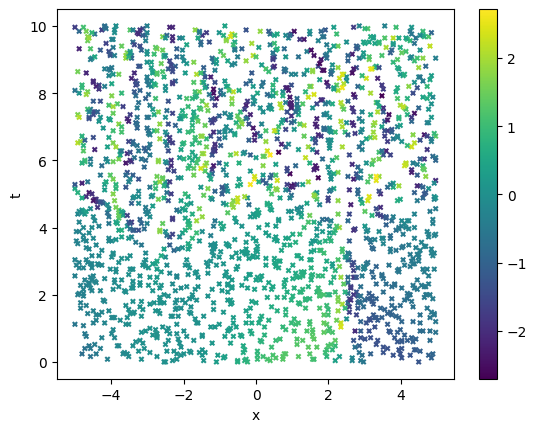

In [42]:
coords = dataset.get_coords().cpu()
data = dataset.get_data().cpu()
fig, ax = plt.subplots()
im = ax.scatter(coords[:,1], coords[:,0], c=data[:,0], marker="x", s=10)
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)

plt.show()

In [43]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

In [44]:
network = Siren(2, [50, 50, 50, 50, 50, 50, 50, 50], 1)

In [45]:
library = Library1D(poly_order=2, diff_order=4) 

In [46]:
estimator = Threshold(0.2) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5) 

In [47]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

In [48]:
model = DeepMoD(network, library, estimator, constraint).to(device)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.999, 0.999), amsgrad=True, lr=2.5e-4) 


In [49]:
%%time
!rm -rf ./data/deepymod/Kuramoto_Sivashinsky_Chaotic/
foldername = "./data/deepymod/Kuramoto_Sivashinsky_Chaotic/"
train(model, 
train_dataloader, 
test_dataloader, 
optimizer,
sparsity_scheduler, 
log_dir=foldername, 
split=0.8, 
max_iterations=100000) 

   725  MSE: 6.39e-01  Reg: 3.86e-03  L1: 0.00e+00 Algorithm converged. Writing model to disk.
CPU times: user 1min 14s, sys: 748 ms, total: 1min 14s
Wall time: 1min 14s


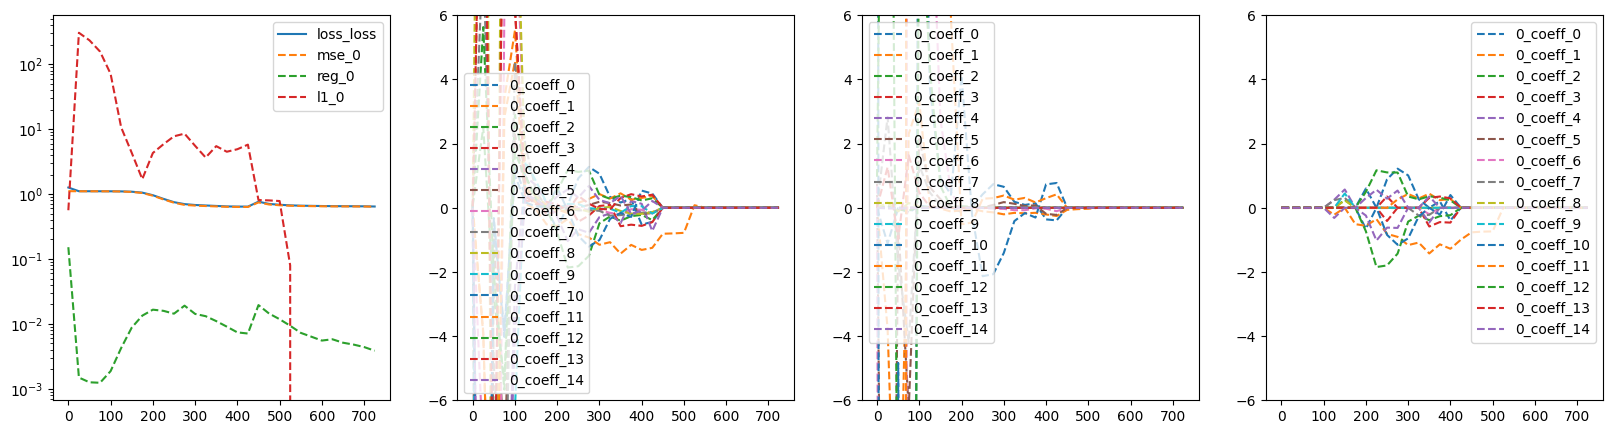

In [53]:
from deepymod.analysis import load_tensorboard
history = load_tensorboard(foldername) 
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for history_key in history.keys():
    history_key_parts = history_key.split("_")
    if history_key_parts[0] == "loss":    
        if history_key_parts[-1] == "0":
            axs[0].semilogy(history[history_key], label=history_key_parts[1]+"_"+history_key_parts[-1], linestyle="--")
        elif history_key_parts[-1] == "1":
            axs[0].semilogy(history[history_key],  label=history_key_parts[1]+"_"+history_key_parts[-1], linestyle=":")
        else:
            axs[0].semilogy(history[history_key],  label=history_key_parts[1]+"_"+history_key_parts[-1], linestyle="-")
        if history_key_parts[0] == "remaining":    
            axs[0].semilogy(history[history_key],  label=history_key_parts[1]+"_"+history_key_parts[3]+"_"+history_key_parts[4], linestyle="-.")
    if history_key_parts[0] == "coeffs":
        if history_key_parts[2] == "0":
            axs[1].plot(history[history_key], label=history_key_parts[2]+"_"+history_key_parts[3]+"_"+history_key_parts[4], linestyle="--")
        elif history_key_parts[2] == "1":
            axs[1].plot(history[history_key], label=history_key_parts[2]+"_"+history_key_parts[3]+"_"+history_key_parts[4], linestyle=":")
        else:
            axs[1].plot(history[history_key], label=history_key_parts[2]+"_"+history_key_parts[3]+"_"+history_key_parts[4], linestyle="-")
    if history_key_parts[0] == "unscaled":    
        if history_key_parts[3] == "0":
            axs[2].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle="--")
        elif history_key_parts[3] == "1":
            axs[2].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle=":")
        else:
            axs[2].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle="-")
    if history_key_parts[0] == "estimator":    
        if history_key_parts[3] == "0":
            axs[3].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle="--")
        elif history_key_parts[3] == "1":
            axs[3].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle=":")
        else:
            axs[3].plot(history[history_key], label=history_key_parts[3]+"_"+history_key_parts[4]+"_"+history_key_parts[5], linestyle="-")

#axs[0].set_ylim([-2, 2])
axs[1].set_ylim([-6, 6])
axs[2].set_ylim([-6, 6])
axs[3].set_ylim([-6, 6])

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

plt.show()


The physical coefficients for the equation
$u_t = -uu_x - u_{xx} - u_{xxxx}$
given the library 
* [$1, u_x, u_{xx}, u_{xxx}, u_{xxxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u u_{xxxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}, u^2 u_{xxxx}$]

In [54]:
model.constraint_coeffs()

[tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]], device='cuda:0', grad_fn=<MaskedScatterBackward0>)]

In [55]:
model.estimator_coeffs()

[array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32)]